In [1]:
!pip install mxnet-cu100

#MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

mx.random.seed(1)

model_ctx = mx.gpu()

In [0]:
def transform(data, label):
    return data.astype('float32')/255.0, label.astype('float32')

train_mnist = gluon.data.vision.FashionMNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.FashionMNIST(train = False, transform = transform)

In [4]:
image, label = train_mnist[0]
print(image.shape, label.shape)

(28, 28, 1) ()


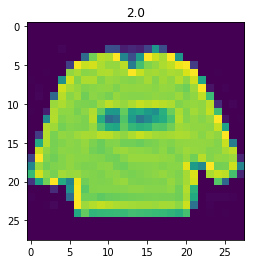

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy())
plt.title(label)
plt.show()


##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
testing_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

##Building the model

In [0]:
weight_scale = .01

#  Allocate parameters for the first hidden layer
W1 = nd.random_normal(shape = (784, 256), scale=weight_scale, ctx=model_ctx)
b1 = nd.random_normal(shape = 256, scale=weight_scale, ctx=model_ctx)

#  Allocate parameters for the second hidden layer
W2 = nd.random_normal(shape = (256, 128), scale=weight_scale, ctx=model_ctx)
b2 = nd.random_normal(shape = 128, scale=weight_scale, ctx=model_ctx)

#  Allocate parameters for the output layer
W3 = nd.random_normal(shape=(128, 10), scale=weight_scale, ctx=model_ctx)
b3 = nd.random_normal(shape=10, scale=weight_scale, ctx=model_ctx)

params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()
    
def neuralnetworks(inputs):
    layer1 = nd.relu(nd.dot(inputs, W1) + b1)
    layer2 = nd.relu(nd.dot(layer1, W2) + b2)
    return nd.softmax(nd.dot(layer2, W3) + b3)

##Defining our objective function

In [0]:
def categoricalcrossentropy(predictions, labels):
    return -nd.sum(labels * nd.log(predictions))

##Defining our parameters optimizer

In [0]:
def sgd(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

##Defining our accuracy function

In [0]:
def accuracy(predictions, labels):
    return nd.mean(predictions.argmax(1) == labels.argmax(1))

##Defining Exponential Based Decay

In [0]:
def exponential_decay(lr, k, epoch):
    return lr * nd.exp(-k * epoch)

##Doing a quick visualization for different drop values for epoch_drop 10

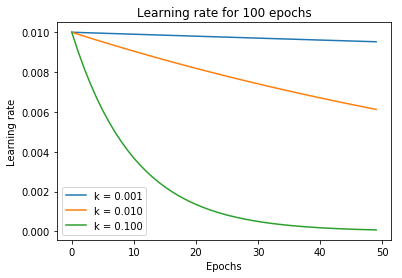

In [12]:
k1 = nd.array([0.001], ctx = model_ctx)
k2 = nd.array([0.01], ctx = model_ctx)
k3 = nd.array([0.1], ctx = model_ctx)

# smaller the k greater the learning rate for upcomming epochs

epochs = 50

initial_lr = nd.array([0.01], ctx = model_ctx)

lrs1 = []
for epoch in range(epochs):
    lr_ = exponential_decay(initial_lr, k1, epoch)
    lrs1.append(lr_.asscalar())

lrs2 = []
for epoch in range(epochs):
    lr_ = exponential_decay(initial_lr, k2, epoch)
    lrs2.append(lr_.asscalar())

lrs3 = []
for epoch in range(epochs):
    lr_ = exponential_decay(initial_lr, k3, epoch)
    lrs3.append(lr_.asscalar())

plt.plot(list(range(epochs)), lrs1, label = f'k = {k1.asscalar():.3f}')
plt.plot(list(range(epochs)), lrs2, label = f'k = {k2.asscalar():.3f}')
plt.plot(list(range(epochs)), lrs3, label = f'k = {k3.asscalar():.3f}')
plt.title('Learning rate for 100 epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.legend()
plt.show()

##Training the  model

In [13]:
epochs = 10
num_batches = 60000//batch_size

initial_learning_rate = nd.array([.001], ctx = model_ctx)
k = nd.array([0.01], ctx = model_ctx)

losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    
    learning_rate = exponential_decay(initial_learning_rate, k, epoch)
    
    for features, labels in training_data:
        features = features.as_in_context(model_ctx).reshape((-1, 784))
        labels = labels.as_in_context(model_ctx).one_hot(10)
        with autograd.record():
            output = neuralnetworks(features)
            loss = categoricalcrossentropy(output, labels)
        loss.backward()
        
        sgd(params, learning_rate)
        
        cumulative_loss += loss
        acc = accuracy(output, labels)
        cumulative_acc += acc
        losses.append(loss.asscalar())
        accs.append(acc.asscalar())
    print(f'Epoch: {epoch} | Loss: {cumulative_loss.asscalar()/num_batches:.5f} | Accuracy: {cumulative_acc.asscalar()/num_batches:.5f} | Learning Rate: {learning_rate.asscalar():.10f}')

Epoch: 0 | Loss: 78.12442 | Accuracy: 0.53895 | Learning Rate: 0.0010000000
Epoch: 1 | Loss: 38.24226 | Accuracy: 0.78547 | Learning Rate: 0.0009900498
Epoch: 2 | Loss: 31.10512 | Accuracy: 0.82701 | Learning Rate: 0.0009801986
Epoch: 3 | Loss: 27.69624 | Accuracy: 0.84367 | Learning Rate: 0.0009704455
Epoch: 4 | Loss: 25.50676 | Accuracy: 0.85686 | Learning Rate: 0.0009607894
Epoch: 5 | Loss: 23.81247 | Accuracy: 0.86591 | Learning Rate: 0.0009512294
Epoch: 6 | Loss: 22.63584 | Accuracy: 0.87148 | Learning Rate: 0.0009417646
Epoch: 7 | Loss: 21.68581 | Accuracy: 0.87810 | Learning Rate: 0.0009323938
Epoch: 8 | Loss: 20.84017 | Accuracy: 0.88209 | Learning Rate: 0.0009231163
Epoch: 9 | Loss: 20.08772 | Accuracy: 0.88676 | Learning Rate: 0.0009139312


##Lets see test accuracy

In [14]:
acc = 0.0
batches = 0
for features, labels in testing_data:
    features = features.as_in_context(model_ctx).reshape((-1, 784))
    labels = labels.as_in_context(model_ctx).one_hot(10)
    predictions = neuralnetworks(features)
    acc += accuracy(predictions, labels)
    batches += 1
print(f'Test Accuracy: {acc.asscalar()/batches}')

Test Accuracy: 0.8796775477707006


In [0]:
def plot(losses = losses, accs = accs, model = neuralnetworks, samples = 5):
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    for i, batch in enumerate(test_mnist):
        features = batch[0].as_in_context(model_ctx).reshape((1, 784))
        labels = batch[1]
        predictions = model(features).argmax(1).asscalar()
        plt.imshow(features.reshape((28, 28)).asnumpy())
        plt.title(f'Predicted Class: {predictions}, Target Class: {labels}')
        plt.show()
        if i == samples:
            break

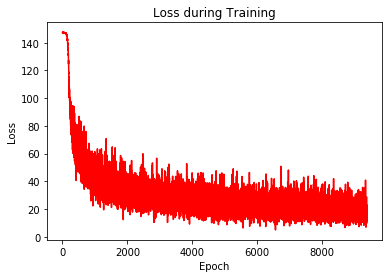

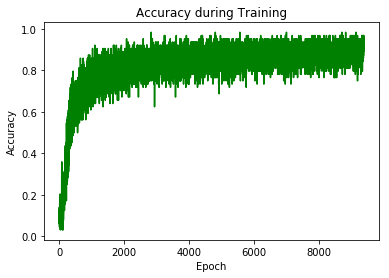

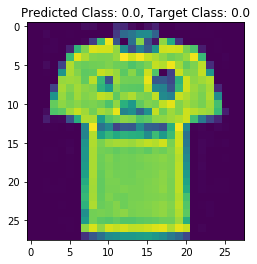

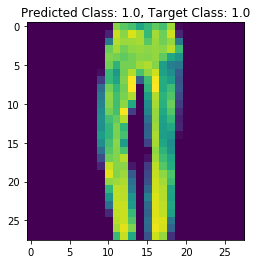

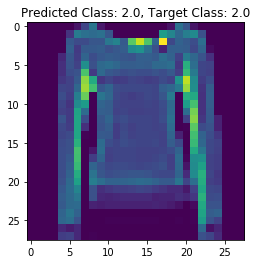

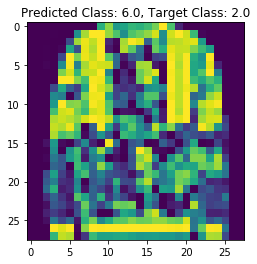

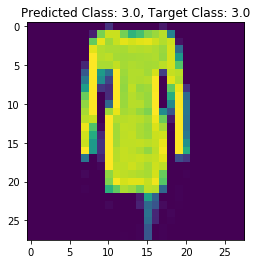

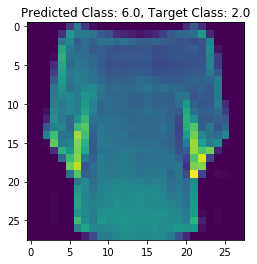

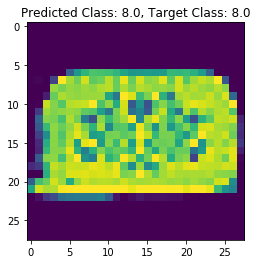

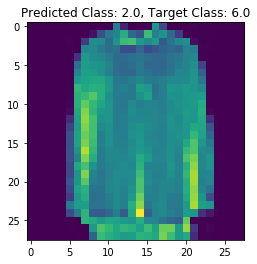

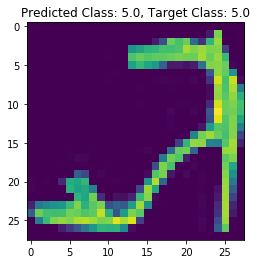

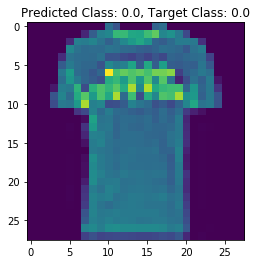

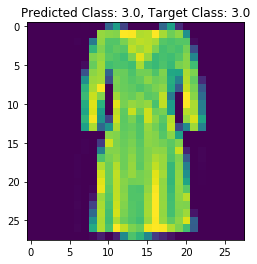

In [16]:
plot(samples = 10)